<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Pytorch-fundamentals-to-deploy/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:** 

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. 
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 3107 (delta 14), reused 34 (delta 12), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 28.68 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data 

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f6db5d48850>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1034 | train_acc: 0.3828 | test_loss: 0.8918 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6602 | test_loss: 0.8103 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.8945 | test_loss: 0.6448 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7616 | train_acc: 0.6992 | test_loss: 0.5864 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6327 | train_acc: 0.8789 | test_loss: 0.6041 | test_acc: 0.9072
[INFO] Total training time: 145.742 seconds


### Make predictions on the entire test dataset with the model

In [69]:
# TODO
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
y_pred_probs = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred_prob = torch.softmax(y_logit.squeeze(), dim=0)
    y_pred = y_pred_prob.argmax(dim=1)

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_pred_probs.append(y_pred_prob.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_prob_tensor = torch.cat(y_pred_probs)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [33]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0


In [34]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.21.0


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2.])

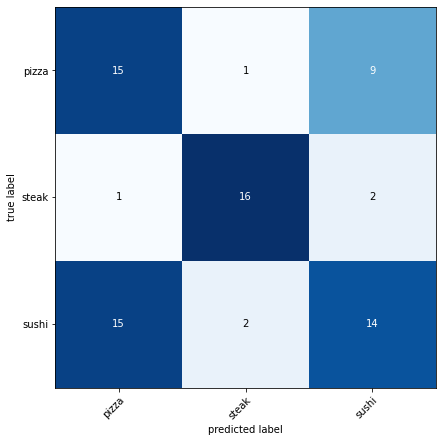

In [41]:
# TODO
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_dataloader.dataset.targets).int())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [62]:
labels = torch.Tensor(test_dataloader.dataset.targets).int()

In [97]:
y_pred_tensor==labels

tensor([ True,  True,  True,  True, False, False,  True,  True,  True,  True,
        False, False, False, False,  True, False,  True, False,  True,  True,
        False,  True,  True,  True, False,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False, False, False,  True, False, False, False, False, False,
        False,  True,  True, False,  True, False, False,  True, False,  True,
        False,  True, False, False,  True])

In [99]:
# TODO
(y_pred_tensor==labels).sort()

torch.return_types.sort(
values=tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]),
indices=tensor([58, 17, 20, 63, 38, 24, 60, 59, 27, 65, 29, 57, 56, 55, 51, 53, 52, 10,
        45, 73, 72,  4,  5, 70, 68, 66, 11, 12, 13, 15, 47, 50, 46, 48, 49, 62,
        54, 61, 37, 64, 67, 69, 71, 74, 26,  1,  2,  3,  6,  7,  8,  9, 14, 16,
        18, 19, 21, 22, 23, 25, 44, 28, 30, 31, 32, 33, 34, 35, 36,  0, 39, 40,
        41, 42, 43]))

In [65]:
labels.shape

torch.Size([75])

In [80]:
sorted.indices[0:5]

tensor([58, 17, 20, 63, 38])

In [81]:
images=test_dataloader.dataset.imgs

In [95]:
[images[x] for x in [58, 17, 20, 63, 38]]

[('data/pizza_steak_sushi/test/sushi/2521706.jpg', 2),
 ('data/pizza_steak_sushi/test/pizza/3475871.jpg', 0),
 ('data/pizza_steak_sushi/test/pizza/540882.jpg', 0),
 ('data/pizza_steak_sushi/test/sushi/3196729.jpg', 2),
 ('data/pizza_steak_sushi/test/steak/3873283.jpg', 1)]

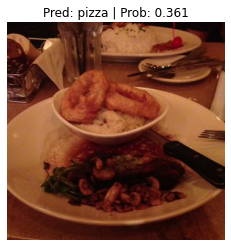

In [102]:
from scipy.spatial import transform
from going_modular.going_modular import predictions

predictions.pred_and_plot_image(model_0,class_names,'data/pizza_steak_sushi/test/steak/3873283.jpg',(224,224),transform=simple_transform,device=device)

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

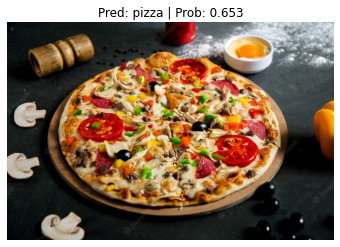

In [103]:
# TODO: Get an image of pizza/steak/sushi
predictions.pred_and_plot_image(model_0,class_names,'/content/data/mixed-pizza-with-various-ingridients_140725-3790.webp',(224,224),transform=simple_transform,device=device)

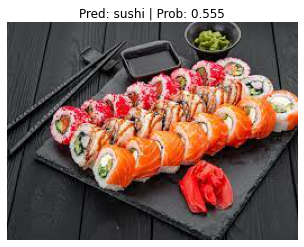

In [104]:
# TODO: Get an image of not pizza/steak/sushi
predictions.pred_and_plot_image(model_0,class_names,'/content/data/indir.jfif',(224,224),transform=simple_transform,device=device)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [105]:
# TODO: Recreate a new model 
model_1 = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [106]:
# TODO: Train the model for 10 epochs
optimizer = torch.optim.Adam(params = model_1.parameters(),lr = 0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1034 | train_acc: 0.3828 | test_loss: 0.8918 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6602 | test_loss: 0.8103 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.8945 | test_loss: 0.6448 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7616 | train_acc: 0.6992 | test_loss: 0.5864 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6327 | train_acc: 0.8789 | test_loss: 0.6041 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5923 | train_acc: 0.7969 | test_loss: 0.5559 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5783 | train_acc: 0.8047 | test_loss: 0.5762 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.5110 | train_acc: 0.7930 | test_loss: 0.4998 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4743 | train_acc: 0.9258 | test_loss: 0.5096 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5413 | train_acc: 0.8047 | test_loss: 0.5349 | test_acc: 0.9176
Epoch: 11 | train_loss: 0.4566 | train_acc: 0.8320 | test_loss: 0.4945 | test_acc: 0.9176
Epoch: 12 | train_l

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### Get 20% data

In [107]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [108]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [109]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f6d97935310>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [111]:
# TODO
model_2 = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train a model with 20% of the data

In [112]:
# TODO
# TODO: Train the model for 10 epochs
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),lr = 0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1034 | train_acc: 0.3828 | test_loss: 0.8918 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6602 | test_loss: 0.8103 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.8945 | test_loss: 0.6448 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7616 | train_acc: 0.6992 | test_loss: 0.5864 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6327 | train_acc: 0.8789 | test_loss: 0.6041 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5923 | train_acc: 0.7969 | test_loss: 0.5559 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5783 | train_acc: 0.8047 | test_loss: 0.5762 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.5110 | train_acc: 0.7930 | test_loss: 0.4998 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4743 | train_acc: 0.9258 | test_loss: 0.5096 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5413 | train_acc: 0.8047 | test_loss: 0.5349 | test_acc: 0.9176
Epoch: 11 | train_loss: 0.4566 | train_acc: 0.8320 | test_loss: 0.4945 | test_acc: 0.9176
Epoch: 12 | train_l

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [115]:
# TODO 
# TODO
model_3 = torchvision.models.efficientnet_b2(weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1408, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [116]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3.parameters(),lr = 0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0959 | train_acc: 0.3359 | test_loss: 0.9660 | test_acc: 0.6411
Epoch: 2 | train_loss: 0.9194 | train_acc: 0.6055 | test_loss: 0.8967 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7495 | train_acc: 0.8320 | test_loss: 0.7993 | test_acc: 0.8144
Epoch: 4 | train_loss: 0.7776 | train_acc: 0.6992 | test_loss: 0.7475 | test_acc: 0.7538
Epoch: 5 | train_loss: 0.6812 | train_acc: 0.7578 | test_loss: 0.6899 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.5922 | train_acc: 0.7891 | test_loss: 0.6171 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5841 | train_acc: 0.7656 | test_loss: 0.5967 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.5378 | train_acc: 0.8086 | test_loss: 0.5688 | test_acc: 0.9271
Epoch: 9 | train_loss: 0.5174 | train_acc: 0.8281 | test_loss: 0.5967 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.4532 | train_acc: 0.9336 | test_loss: 0.5258 | test_acc: 0.9072
Epoch: 11 | train_loss: 0.5125 | train_acc: 0.8203 | test_loss: 0.5237 | test_acc: 0.8864
Epoch: 12 | train_l